# Tarefa Dataset Grupo

### Produção Energética e Sustentabilidade

https://www.kaggle.com/competitions/daasbstp2023

Imports Necessários

In [183]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#USING CROSS VALIDATION
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import re
import seaborn as sns


Ingestão de Dados

In [184]:
df_energia_2021 = pd.read_csv('energia_202109-202112.csv')
print (df_energia_2021.size)
df_energia_2022 = pd.read_csv('energia_202201-202212.csv')
df_meteo_2021 = pd.read_csv('meteo_202109-202112.csv')
df_meteo_2022 = pd.read_csv('meteo_202201-202212.csv')

#ver os cabeçalhos para fazer merge por data e hora

print(df_energia_2021.head())
print(df_meteo_2021.head())


# o dia era interessante fazer com o dia do ano -1 até 365. Não há anos bissextos, não há problema
print (df_meteo_2021.dtypes)
print (df_energia_2021.dtypes)
print (df_meteo_2021['dt_iso'])
form = re.compile(r'(\d{4}-\d{2}-\d{2})\s(\d{2}):\d{2}:\d{2}\s\+\d{4}\sUTC')
#df_meteo_2021['Data'],df_meteo_2021['Hora'] =df_meteo_2021['dt_iso'].str.extract(form)

#desdobrar data para o dataset meteorológico de 2021
data= df_meteo_2021['dt_iso'].str.extract(form)
df_meteo_2021['Data']= data[0]
df_meteo_2021['Hora']= pd.to_numeric(data[1])
#df_meteo_2021['Data'], df_meteo_2021['Hora'] = zip(*df_meteo_2021['dt_iso'].str.extract(form).values)
df_meteo_2021.drop(['dt_iso'], axis='columns', inplace=True)

#desdobrar data para o dataset meteorológico de 2022
data= df_meteo_2022['dt_iso'].str.extract(form)
df_meteo_2022['Data']= data[0]
df_meteo_2022['Hora']= pd.to_numeric(data[1])
#df_meteo_2022['Data'], df_meteo_2022['Hora'] = zip(*df_meteo_2022['dt_iso'].str.extract(form).values)
df_meteo_2022.drop(['dt_iso'], axis='columns', inplace=True)

print (df_meteo_2021.head())
print (df_meteo_2022.head())

df_2021 = pd.merge(df_energia_2021,df_meteo_2021, how='inner', on=['Data','Hora']) 
df_2022 = pd.merge(df_energia_2022,df_meteo_2022, how='inner', on=['Data','Hora'])

df_train= pd.concat([df_2021, df_2022], ignore_index=True)

##TESTE

df_energia_2023 = pd.read_csv('energia_202301-202304.csv')
df_meteo_2023 = pd.read_csv('meteo_202301-202304.csv')

#desdobrar data para o dataset meteorológico de 2023
data= df_meteo_2023['dt_iso'].str.extract(form)
df_meteo_2023['Data']= data[0]
df_meteo_2023['Hora']= pd.to_numeric(data[1])
#df_meteo_2022['Data'], df_meteo_2022['Hora'] = zip(*df_meteo_2022['dt_iso'].str.extract(form).values)
df_meteo_2023.drop(['dt_iso'], axis='columns', inplace=True)

df_2023 = pd.merge(df_energia_2023,df_meteo_2023, how='left', on=['Data','Hora']) 


13536
         Data  Hora  Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)  \
0  2021-09-29     0           0.0                      0.0                0.0   
1  2021-09-29     1           0.0                      0.0                0.0   
2  2021-09-29     2           0.0                      0.0                0.0   
3  2021-09-29     3           0.0                      0.0                0.0   
4  2021-09-29     4           0.0                      0.0                0.0   

  Injecao na rede (kWh)  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
           dt                         dt_iso city_name   temp  feels_like  \
0  1630454400  2021-09-01 00:00:00 +0000 UTC     local  18.74       18.84   
1  1630458000  2021-09-01 01:00:00 +0000 UTC     local  18.73       18.83   
2  1630461600  2021-09-01 02:00:00 +0000 UTC     local  17.84       17.98   
3  1630465200  2021-09-01 03:00:00 +0000 UT

Análise de Dados


(2256, 6)
            Data  Hora  Normal (kWh)  Horario Economico (kWh)  \
2251  2021-12-31    19         2.176                    0.000   
2252  2021-12-31    20         0.732                    0.000   
2253  2021-12-31    21         0.704                    0.000   
2254  2021-12-31    22         0.000                    0.424   
2255  2021-12-31    23         0.000                    0.432   

      Autoconsumo (kWh) Injecao na rede (kWh)  
2251                0.0                   NaN  
2252                0.0                   NaN  
2253                0.0                   NaN  
2254                0.0                   NaN  
2255                0.0                   NaN  
Data                           0
Hora                           0
Normal (kWh)                   0
Horario Economico (kWh)        0
Autoconsumo (kWh)              0
Injecao na rede (kWh)       7777
dt                             0
city_name                      0
temp                           0
feels_like    

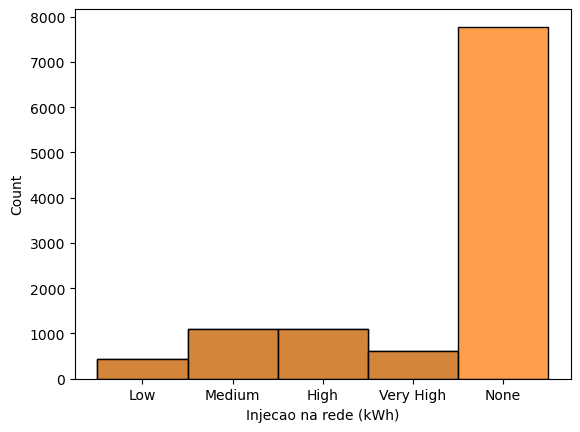

In [185]:



print (df_energia_2021.shape)
print(df_energia_2021.tail())
print (df_train.isna().sum())
sns.histplot(df_train["Injecao na rede (kWh)"])
df_train=df_train.fillna({'Injecao na rede (kWh)': 'None'})
print (df_train.isna().sum())
sns.histplot(df_train["Injecao na rede (kWh)"])


print (df_train.shape) # verfiicar se o número de linhas está correto



Tratamento de Dados

Data                        object
Hora                         int64
Normal (kWh)               float64
Horario Economico (kWh)    float64
Autoconsumo (kWh)          float64
Injecao na rede (kWh)       object
dt                           int64
city_name                   object
temp                       float64
feels_like                 float64
temp_min                   float64
temp_max                   float64
pressure                     int64
sea_level                  float64
grnd_level                 float64
humidity                     int64
wind_speed                 float64
rain_1h                    float64
clouds_all                   int64
weather_description         object
dtype: object
Data                           0
Hora                           0
Normal (kWh)                   0
Horario Economico (kWh)        0
Autoconsumo (kWh)              0
Injecao na rede (kWh)          0
dt                             0
city_name                      0
temp                  

0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
         ...  
11011    0.000
11012    0.000
11013    0.000
11014    0.675
11015    0.403
Name: Horario Economico (kWh), Length: 11016, dtype: float64


"\n#churn to nominal\ndf['Churn'] = df['Churn'].astype('category') #.apply(str)\nprint(df.dtypes)\n\n# fazer um matplotlib com os churns \n#print(df.head())\n\nx = df.drop(['Churn','State','Phone'], axis=1)\ny = df['Churn'].to_frame()\n\nx_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)\n\nclf = DecisionTreeClassifier(random_state=2021)\n\nclf.fit(x_train, y_train)\n\npredict = clf.predict(x_test)\n\nconfusion_matrix = confusion_matrix(y_test, predict)\n\nprint(confusion_matrix)\n\nprint(confusion_matrix)\n\naccuracy = accuracy_score(y_test, predict)\n\nprint(accuracy)\n\nprecision = precision_score(y_test, predict)\n\nprint(precision)\n\nrecall = recall_score(y_test, predict)\n\nprint(recall)\n\n"

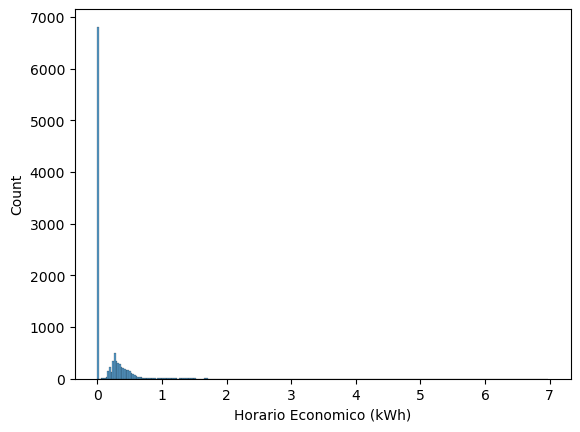

In [186]:
print(df_train.dtypes)
print (df_train.isna().sum())
#print(f"History: {df_train["Horario Economico (kWh)"].hist()}")
sns.histplot(df_train["Horario Economico (kWh)"])
print(df_train["Horario Economico (kWh)"])
#print(dfCSV.head())
#print(dfXLS.head())

#df = pd.merge(dfCSV, dfXLS, how='inner', on=['Phone','Area Code']) # rever inner join
#print(df.head())

#print(df.describe())
#print(df.shape)
#print(df.dtypes)

"""
#churn to nominal
df['Churn'] = df['Churn'].astype('category') #.apply(str)
print(df.dtypes)

# fazer um matplotlib com os churns 
#print(df.head())

x = df.drop(['Churn','State','Phone'], axis=1)
y = df['Churn'].to_frame()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)

clf = DecisionTreeClassifier(random_state=2021)

clf.fit(x_train, y_train)

predict = clf.predict(x_test)

confusion_matrix = confusion_matrix(y_test, predict)

print(confusion_matrix)

print(confusion_matrix)

accuracy = accuracy_score(y_test, predict)

print(accuracy)

precision = precision_score(y_test, predict)

print(precision)

recall = recall_score(y_test, predict)

print(recall)

"""

Aprendizagem Supervisionada

In [187]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

print(df_train["Injecao na rede (kWh)"])

data= pd.DataFrame({'Injecao na rede (kWh)': ['None', 'Low', 'Medium', 'High', 'Very High']})

label_encoder = LabelEncoder()
df_train['Injecao na rede (kWh)'] = label_encoder.fit_transform(df_train['Injecao na rede (kWh)'])

# Features and target
x = df_train[["Normal (kWh)","Horario Economico (kWh)","Autoconsumo (kWh)","temp","feels_like","temp_min","temp_max","pressure","humidity","wind_speed","clouds_all"]]
y = df_train["Injecao na rede (kWh)"]

print(y)

# Train the linear regression model
lm = LinearRegression()
lm.fit(x, y)

# Your df_2023 data and cleaning operations remain the same

print(df_2023)
df_2023.drop(['Data'], axis='columns', inplace=True)
df_2023.drop(['Hora'], axis='columns', inplace=True)
df_2023.drop(['city_name'], axis='columns', inplace=True)
df_2023.drop(['grnd_level'], axis='columns', inplace=True)
df_2023.drop(['rain_1h'], axis='columns', inplace=True)
df_2023.drop(['sea_level'], axis='columns', inplace=True)
df_2023.drop(['weather_description'], axis='columns', inplace=True)
df_2023.drop(['dt'], axis='columns', inplace=True)


# Make predictions
print("OLE")
print(df_2023)
prediction = lm.predict(df_2023)
prediction1=[]
for elem in prediction:
    if elem <0.5:
        prediction1.append('High')
    elif elem <1.5:
        prediction1.append('Low')
    elif elem <2.5:
        prediction1.append('Medium') 
    elif elem <3.5:
        prediction1.append('None') 
    elif elem <4.5:
        prediction1.append('Very High')  

# Create a DataFrame with 'RowId' and 'Result'
data = pd.DataFrame({'RowId': range(1, len(df_2023) + 1), 'Result': prediction1})

# Save the data to a CSV file
data.to_csv('predictions.csv', index=False)

# Print the predictions
print("Predictions:")
print(prediction)

0        None
1        None
2        None
3        None
4        None
         ... 
11011    None
11012    None
11013    None
11014    None
11015    None
Name: Injecao na rede (kWh), Length: 11016, dtype: object
0        3
1        3
2        3
3        3
4        3
        ..
11011    3
11012    3
11013    3
11014    3
11015    3
Name: Injecao na rede (kWh), Length: 11016, dtype: int64
            Data  Hora  Normal (kWh)  Horario Economico (kWh)  \
0     2023-01-01     0         0.000                    0.467   
1     2023-01-01     1         0.000                    0.577   
2     2023-01-01     2         0.000                    0.346   
3     2023-01-01     3         0.000                    0.270   
4     2023-01-01     4         0.000                    0.252   
...          ...   ...           ...                      ...   
2251  2023-04-04    19         0.953                    0.000   
2252  2023-04-04    20         0.915                    0.000   
2253  2023-04-04    21   

OLE
      Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)   temp  \
0            0.000                    0.467              0.000  12.93   
1            0.000                    0.577              0.000  13.49   
2            0.000                    0.346              0.000  13.55   
3            0.000                    0.270              0.000  13.61   
4            0.000                    0.252              0.000  13.59   
...            ...                      ...                ...    ...   
2251         0.953                    0.000              0.012    NaN   
2252         0.915                    0.000              0.000    NaN   
2253         0.479                    0.000              0.000    NaN   
2254         0.000                    0.497              0.000    NaN   
2255         0.000                    0.487              0.000    NaN   

      feels_like  temp_min  temp_max  pressure  humidity  wind_speed  \
0          12.76     12.72     13.43    1019.0 

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Geração da submission